Please create a folder named `data` in the main directory and place the following files inside it:

- `Reddit-Threads_2020-2021.csv`
- `Reddit-Threads_2022-2023.csv`

In [56]:
import pandas as pd
import ast
import torch
import torch.nn as nn
import transformers
from transformers import pipeline
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import requests
import os
from dotenv import load_dotenv
import time
from huggingface_hub import login
import google.generativeai as genai
import os
from tqdm import tqdm
from datasets import Dataset
import json
from openai import OpenAI
import numpy as np
from sklearn.metrics import f1_score
import random

# huggingface API key
hf_api_key = os.getenv('HUGGINGFACE_API_KEY')
login(token=hf_api_key)

if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f'Device in use: {device_name}')
else:
    device = torch.device("cpu")
    print('Device in use: CPU')

load_dotenv()

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\caboo\.cache\huggingface\token
Login successful
Device in use: NVIDIA GeForce RTX 3080 Laptop GPU


True

# Reading in data

In [57]:
df = pd.DataFrame()

###   SMALL DATASET   ###
# df = pd.read_csv('data/Reddit-Threads_2020-2021.csv', nrows=10000)
# print(df.head())
###   SMALL DATASET   ###

###   FULL DATASET   ###
# chunk_size = 10000
# for chunk in pd.read_csv('data/Reddit-Threads_2020-2021.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
# for chunk in pd.read_csv('data/Reddit-Threads_2022-2023.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
###   FULL DATASET   ###

###   VALIDATION DATASET   ###
df = pd.read_csv('data/labeled_data.csv')
print(df.head())

print(df.shape)


                                                text            timestamp  \
0     Expensive eh now that Uglyfoods closed down :(  2023-01-30 01:04:43   
1                How dare you.. wan go lim kopi ah??  2022-05-04 18:57:57   
2  Yeah the governments can politick all they wan...  2022-06-28 13:44:33   
3               Hijacks event, then complains. Wild.  2022-07-12 07:29:47   
4  Hate to break it to you. But once someone accu...  2023-08-23 02:08:16   

              username                                               link  \
0      MangoDangoLango  /r/singapore/comments/10nqt5h/rsingapore_rando...   
1               900122  /r/SingaporeRaw/comments/ui0rmg/dont_take_offe...   
2  DisillusionedSinkie  /r/singapore/comments/vmb197/malaysias_top_tal...   
3            nehjipain  /r/singapore/comments/vx42x1/nus_student_tried...   
4          KeenStudent  /r/singapore/comments/15ybdme/sorry_doesnt_cut...   

      link_id   parent_id       id subreddit_id  \
0  t3_10nqt5h  t1_j6dwx

# Cleaning

In [58]:
# df['moderation'] = df['moderation'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# moderation_dicts = df['moderation']
# moderation_normalized = pd.json_normalize(moderation_dicts)
# # print(moderation_normalized)
# df = df.reset_index(drop=True)
# moderation_normalized = moderation_normalized.reset_index(drop=True)
# df_normalized = pd.concat([df.drop(columns=['moderation']), moderation_normalized], axis=1)
# print(df_normalized.columns)
df_normalized = df

### removing deleted or removed text ###
df_normalized = df_normalized[df_normalized['text'] != '[deleted]']
df_normalized = df_normalized[df_normalized['text'] != '[removed]']
### removing deleted or removed text ###

### stop word removal ###
# stop_words = set(stopwords.words('english'))

# def remove_stop_words(text):
#     if isinstance(text, str):  # Check if the text is a string
#         return ' '.join([word for word in text.split() if word.lower() not in stop_words])
#     return text 

# df_normalized['text'] = df_normalized['text'].apply(remove_stop_words)
# print(df_normalized['text'])
# print(stop_words)
### stop word removal ###

In [59]:
print(df.columns)

Index(['text', 'timestamp', 'username', 'link', 'link_id', 'parent_id', 'id',
       'subreddit_id', 'moderation', 'toxic', 'hateful'],
      dtype='object')


C:\Users\caboo\AppData\Local\Temp\ipykernel_2144\628181459.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


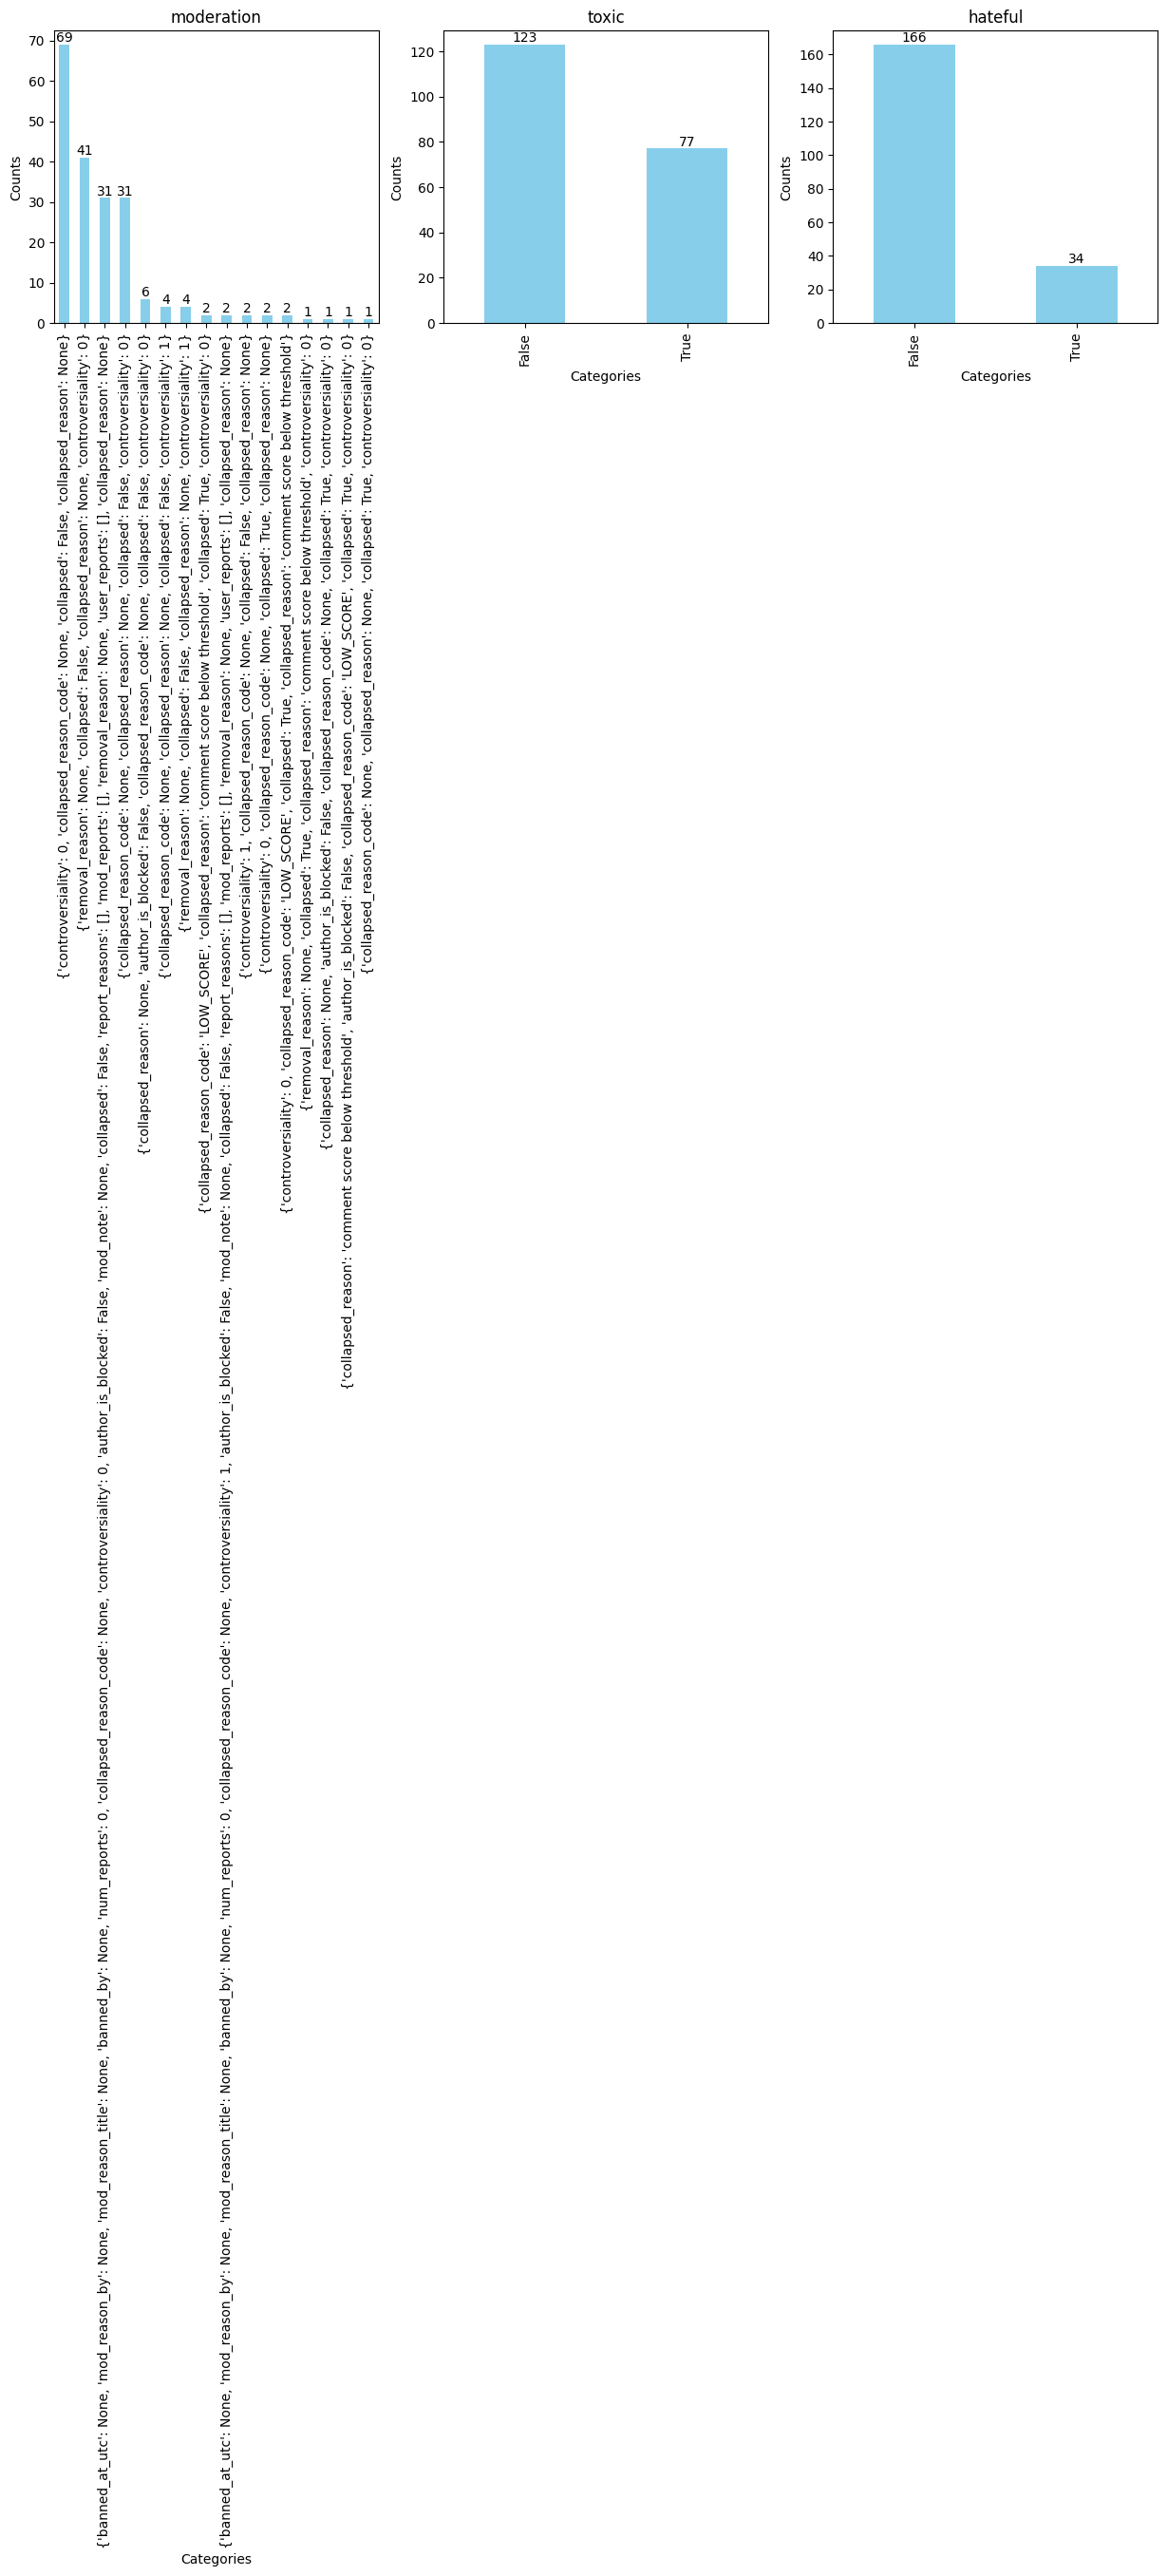

In [60]:
df_for_plot = df_normalized.copy()
df_for_plot.fillna('Not specified', inplace=True)


exclude_columns = [
    'text', 
    'timestamp', 
    'username', 
    'link', 
    'link_id', 
    'parent_id', 
    'id', 
    'subreddit_id'
]
columns_to_plot = [col for col in df_normalized.columns if col not in exclude_columns]


num_columns = len(columns_to_plot)
cols = 3  
rows = (num_columns + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    counts = df_for_plot[column].value_counts()
    if not counts.empty:
        bars = counts.plot(kind='bar', ax=axes[i], color='skyblue')
        axes[i].set_title(column)
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel('Counts')

        for bar in bars.patches:
            axes[i].annotate(format(int(bar.get_height())), 
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                ha='center', va='bottom')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

# 2 Using LLMs to label our data (Huggingface)

In [61]:
def toxic_prompt(text):
    return f"""
<s>[INST] <<SYS>>
You are a moderator on a social media platform. You are reviewing a user's comment to determine if it is toxic. 
Please respond with a number from 0 (not toxic) to 1 (very toxic) for the following comment.
<</SYS>>
{text} [/INST]
"""


def hate_prompt(text):
    return(f"""Give me a score between 0 and 1 of how hateful the text is. Note this is in the singaporean context:

Text: "{text}"
""")




In [62]:
# toxic_classifier = pipeline("text-generation", model='meta-llama/Llama-3.1-8B', device=torch.device("cpu"))
# # toxic_classifier.model.eval()

# response = toxic_classifier(
#     hate_prompt("banana"),
#     max_new_tokens=50,
#     do_sample=False,
#     truncation=True
# )

# # response = toxic_classifier(
# #     'Please classify the following comment as toxic or non-toxic: "I hate you."',
# #     max_new_tokens=50,
# #     do_sample=False,
# #     truncation=True
# # )

# print(response)

# del toxic_classifier

In [63]:
# from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# # Load the LLaMA model (use a proper path to your model)
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

# # Define a toxicity rating prompt
# prompt = """
# <s>[INST] <<SYS>>
# You are a moderator on a social media platform. You are reviewing a user's comment to determine if it is toxic. 
# Please respond with a number from 0 (not toxic) to 1 (very toxic) for the following comment.
# <</SYS>>
# rate the to'banana slammer' [/INST]
# """

# inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
# # Call the generate function without 'truncation'
# outputs = model.generate(**inputs, max_new_tokens=50, do_sample=False)
# response = tokenizer.decode(outputs[0], skip_special_tokens=True)

# print(response)

## 2.1 toxic-bert


In [64]:
toxic_classifier = pipeline("text-classification", model="unitary/toxic-bert", return_all_scores=True, device=device)
df_normalized['BERT_toxic'] = False

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity"):
    text = row['text']

    try:
        toxic_prediction = toxic_classifier(text)
        for pred in toxic_prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'toxic' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_toxic'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del toxic_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_toxic'].value_counts())
toxic_samples = df_normalized[df_normalized['BERT_toxic'] == 1].sample(n=5, random_state=42) 
non_toxic_samples = df_normalized[df_normalized['BERT_toxic'] == 0].sample(n=5, random_state=42)

with pd.option_context('display.max_colwidth', None):
    print("5 Toxic Samples:")
    print(toxic_samples['text'])

    print("\n5 Non-Toxic Samples:")
    print(non_toxic_samples['text'])

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying toxicity: 100%|██████████| 200/200 [00:04<00:00, 49.71it/s]

BERT_toxic
False    159
True      41
Name: count, dtype: int64
5 Toxic Samples:
135                                                                                                                                                                                                                                                                                                           It's clear she doesnt give a fook
96                                                                                                                                                                                                                                                                                   I DO NOT WANT MASK MANDATE IN 2025. Don’t fucking curse it
52                                                                                                                                                                                                                                                      

## 2.2 unhcr/hatespeech-detection

In [65]:
hate_classifier = pipeline("text-classification", model="unhcr/hatespeech-detection", return_all_scores=True, device=device)
df_normalized['BERT_hate'] = True

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying hate speech"):
    text = row['text']

    try:
        hate_prediction = hate_classifier(text)
        for pred in hate_prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'Normal' and score < 0.995:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_hate'] = False
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del hate_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_hate'].value_counts())
hate_samples = df_normalized[df_normalized['BERT_hate'] == 1].sample(n=5, random_state=42) 
non_hate_samples = df_normalized[df_normalized['BERT_hate'] == 0].sample(n=5, random_state=42)

with pd.option_context('display.max_colwidth', None):
    print("5 hate Samples:")
    print(hate_samples['text'])

    print("\n5 Non-hate Samples:")
    print(non_hate_samples['text'])

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying hate speech:  66%|██████▌   | 131/200 [00:02<00:01, 61.68it/s]

Error processing toxicity at index 121: The expanded size of the tensor (532) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 532].  Tensor sizes: [1, 514]


Classifying hate speech: 100%|██████████| 200/200 [00:03<00:00, 59.75it/s]

BERT_hate
False    124
True      76
Name: count, dtype: int64
5 hate Samples:
12                                                                                                                                                                                                                                                                                                                                  Dreading going back to work on Monday. Had such a nice time cleaning my house on the weekend.?
73     Just to clarify,  when I say "legality will matter more", I meant abortion being illegal will have a bigger impact on how difficult one could seek abortion services. If it was in limbo like S377A I doubt HCPs would want to risk it by offering the service. Compared to private sex whereby no one cares if it is illegal or not anyway. Not so much which issue is more important or the population of those affected.
25                                                                                  

## 2.3 textdetox/xlmr-large-toxicity-classifier
https://huggingface.co/textdetox/xlmr-large-toxicity-classifier

In [66]:
toxic_classifier = pipeline("text-classification", model="textdetox/xlmr-large-toxicity-classifier", return_all_scores=True, device=device)
df_normalized['BERT_2_toxic'] = False

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity"):
    text = row['text']

    try:
        toxic_prediction = toxic_classifier(text)
        for pred in toxic_prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'toxic' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_2_toxic'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del toxic_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_2_toxic'].value_counts())
toxic_samples = df_normalized[df_normalized['BERT_2_toxic'] == 1].sample(n=5, random_state=42) 
non_toxic_samples = df_normalized[df_normalized['BERT_2_toxic'] == 0].sample(n=5, random_state=42)

with pd.option_context('display.max_colwidth', None):
    print("5 Toxic Samples:")
    print(toxic_samples['text'])

    print("\n5 Non-Toxic Samples:")
    print(non_toxic_samples['text'])

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying toxicity:  64%|██████▍   | 128/200 [00:02<00:01, 67.02it/s]

Error processing toxicity at index 121: The expanded size of the tensor (547) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 547].  Tensor sizes: [1, 514]


Classifying toxicity: 100%|██████████| 200/200 [00:03<00:00, 63.30it/s]


BERT_2_toxic
False    154
True      46
Name: count, dtype: int64
5 Toxic Samples:
169    Pretty bold statement considering the western mindset is vastly different from an asian one. The people there value freedom and their amendments. So unless a draconian way of subduing the general public is implemented, it'd be hard for a iron fist style of govt to succeed there.
117                                                                                                                                                            How about \n\nMr do u have something shoved up your ass since youre being so uptight? \n\nNow that is an unfriendly salutation.
118    Your question makes no sense that’s why he doesn’t want to debate with you. It’s like me asking “do you think you’re stupid or so you think you have an ulterior motive for asking your question” and then insisting you can only pick one or the other for “discussion”’purposes. Err?
187                                                      

## 2.4 sileod/deberta-v3-base-tasksource-toxicity (hate detection)
https://huggingface.co/sileod/deberta-v3-base-tasksource-toxicity

In [67]:
hate_classifier = pipeline("text-classification", model="sileod/deberta-v3-base-tasksource-toxicity", return_all_scores=True, device=device)
df_normalized['BERT_2_hate'] = False

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying hate speech"):
    text = row['text']

    try:
        hate_prediction = hate_classifier(text)
        for pred in hate_prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'hate' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_2_hate'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del hate_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_2_hate'].value_counts())
hate_samples = df_normalized[df_normalized['BERT_2_hate'] == 1].sample(n=5, random_state=42) 
non_hate_samples = df_normalized[df_normalized['BERT_2_hate'] == 0].sample(n=5, random_state=42)

with pd.option_context('display.max_colwidth', None):
    print("5 hate Samples:")
    print(hate_samples['text'])

    print("\n5 Non-hate Samples:")
    print(non_hate_samples['text'])

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying hate speech: 100%|██████████| 200/200 [00:07<00:00, 25.87it/s]


BERT_2_hate
False    170
True      30
Name: count, dtype: int64
5 hate Samples:
186                                                                                                                                                                                                      Yeah it's okay to beat up a mentally unsound person just because we shook hands guys.
110                                                                                                          100%. My friend got assaulted, police came and asked him to shake hands with the guy who assaulted him lol. No charges no nothing. Cops are fucking useless if you get beaten up.
147                                                                                                                                                                                           Same nasty shitheads that say all the unvaccinated should die, and where is the outrage on that?
118    Your question makes no sense that’s why he doesn’t w

In [68]:
print(df_normalized['hateful'].value_counts())
print(df_normalized['BERT_hate'].value_counts())
print(df_normalized['BERT_2_hate'].value_counts())

print('\n')

print(df_normalized['toxic'].value_counts())
print(df_normalized['BERT_toxic'].value_counts())
print(df_normalized['BERT_2_toxic'].value_counts())


hateful
False    166
True      34
Name: count, dtype: int64
BERT_hate
False    124
True      76
Name: count, dtype: int64
BERT_2_hate
False    170
True      30
Name: count, dtype: int64


toxic
False    123
True      77
Name: count, dtype: int64
BERT_toxic
False    159
True      41
Name: count, dtype: int64
BERT_2_toxic
False    154
True      46
Name: count, dtype: int64
